In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time 
import torch
import gym
import dacmdp
import dacmdp.envs as ce
import wandb as wandb_logger


/nfs/guille/afern/users/shrestaa/installation_files/MinicondaInstallation/envs/mondac_env4/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/nfs/guille/afern/users/shrestaa/installation_files/MinicondaInstallation/envs/mondac_env4/lib/python3.10/site-packages/mujoco_py/builder.py:9: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
  from distutils.sysconfig import customize_compiler
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/nfs/guille/afern/users/shrestaa/installation_files/MinicondaInstallation/envs/mondac_env4/lib/python3.10/site-packages/glfw/__init__.py:912: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'

In [3]:
from munch import munchify 

config = munchify({
"envArgs":{'env_name': 'CartPole-cont-v1', 'seed': 0},
"logArgs":{'wandb_id': "cartpole_online_test_1", "wandb_entity":"dacmdp",
           "wandb_project":"dacmdp_online_test_v0", "no_wandb_logging":True},
"dataArgs": {'buffer_name': 'random', 'buffer_size': 25000, 
             'load_buffer': False, 'buffer_device': 'gpu', "data_dir":""},
"reprModelArgs": {'repr_model_name': 'OracleDynamicsRepr', 's_multiplyer': 1, 'a_multiplyer': 10, 'repr_dim': 4},
"actionModelArgs": {'action_model_name': 'NNActionModelCuda', 'nn_engine': "torch_pykeops"},
"mdpBuildArgs": {'n_tran_types': 10, 'n_tran_targets': 5, 'penalty_beta': 10, 'penalty_type': 'linear', 'rebuild_mdpfcache': False,
                 'save_mdp2cache': False, 'save_folder': '/nfs/hpc/share/shrestaa/storage/dac_storage_22_Q4/mdp_dumps/random_hash'},
"mdpSolveArgs": {'device': 'cuda', 'max_n_backups': 5000, "gamma": 0.99, 'epsilon': 0.0001, 'penalty_beta': 1, "operator": "simple_backup"},
"evalArgs": {'eval_episode_count': 50, "skip_eval":True, "skip_dist_log":True},
})

flat_args = lambda config : {f"{K}::{k}":v for K in config for k,v in config[K].items() if K != "flat_args"}

In [4]:
config.logArgs

Munch({'wandb_id': 'cartpole_online_test_1', 'wandb_entity': 'dacmdp', 'wandb_project': 'dacmdp_online_test_v0', 'no_wandb_logging': True})

In [5]:
if not config.logArgs.no_wandb_logging:
    wandb_logger.init( id = config.logArgs.wandb_id ,
        entity=config.logArgs.wandb_entity,
        project=config.logArgs.wandb_project,
        config = flat_args(config),
        resume = "allow")

In [6]:
env = gym.make(config.envArgs.env_name)

In [7]:
from dacmdp.core.models_action import NNActionModel, GlobalClusterActionModel, EnsembleActionModel
from dacmdp.core.models_sa_repr import OracleDynamicsRepr, DeltaPredictonRepr

######### Get Action and Repr Models ####################################
seed_buffer = dacmdp.utils_buffer.generate_or_load_buffer(config, env)
cluster_action_count = 10
cluster_action_model = GlobalClusterActionModel(action_space=env.action_space,
                                   n_actions= cluster_action_count,
                                   data_buffer=seed_buffer)

sa_repr_model = OracleDynamicsRepr(env_name = config.envArgs.env_name)
# sa_repr_model = DeltaPredictonRepr(s_multiplyer=2, 
#                                    a_multiplyer=1,
#                                    buffer=data_buffer_train,
#                                    nn_engine="torch_pykeops")
######################################################################################################

Average Reward of collected trajectories:17.164
Collected buffer!


In [8]:
cluster_action_model.cand_actions_for_states(torch.FloatTensor(seed_buffer.state[0:100]).cuda()).shape,\
sa_repr_model.encode_state_action_pairs(torch.FloatTensor(seed_buffer.state[0:100]),
                                       torch.FloatTensor(seed_buffer.action[0:100])).shape

/nfs/guille/afern/users/shrestaa/workspaces/dacmdp/dacmdp/envs/cont_cartpole.py:104: UserWarning: WARN: 
You are calling 'step()' even though this environment has already returned
done = True. You should always call 'reset()' once you receive 'done = True'
Any further steps are undnp.float32(low), np.float32(high)efined behavior.
                
  logger.warn("""


(torch.Size([100, 10, 1]), torch.Size([100, 4]))

In [9]:
from collections import defaultdict
from tqdm import tqdm 

def get_replacable_indices(Agent, target_replace_ratio):
    nn,aa,sa_dim = Agent.dacmdp_core.T_repr[:,5:,:].shape
    s_repr = Agent.dacmdp_core.T_repr[:,5:,:].reshape(nn,aa*sa_dim).contiguous()
    knn_indices, knn_distances = THelper.batch_calc_knn_pykeops(s_repr, s_repr, k = 2)
    nn_distances = knn_distances[:, 1]
    candidate_indices = torch.nonzero(nn_distances <= torch.quantile(nn_distances, target_replace_ratio + 0.05)).reshape(-1)
    candidate_root_indices = knn_indices[candidate_indices][:,1]
    
    is_replacable = defaultdict(lambda: 1)
    replace_indices = []
    for c,cr in tqdm(zip(candidate_indices, candidate_root_indices)):
        c,cr = c.item(), cr.item()
        if is_replacable[c]:
            replace_indices.append(c)
            is_replacable[cr] = False
    return replace_indices

In [10]:
from dacmdp.data.utils_buffer import StandardElasticBuffer
global_buffer = StandardElasticBuffer(state_shape = env.observation_space.shape,
               action_shape = [len(env.action_space.sample())], # for discrete settings. 
                batch_size=32, buffer_size=100000, device="cpu")
# policy liftup functions
def dummy_lifted_policy(Agent, s, epsilon):
    if torch.rand(1).item() < epsilon:
        return env.action_space.sample()
    else:
        nn_s_idx =  THelper.calc_knn_indices(torch.FloatTensor(s).to(Agent.device), Agent.dacmdp_core.S, 1)[0]
        policy_idx = Agent.dacmdp_core.Pi[nn_s_idx] 
        return Agent.A_names[nn_s_idx,policy_idx].cpu().numpy()

In [11]:
import time
import matplotlib.pyplot as plt 
import numpy as np 
import copy
from dacmdp.core.utils_misc import plot_distributions_as_rgb_array
from dacmdp.eval.utils_eval import evaluate_on_env
from dacmdp.data.utils_buffer import StandardBuffer
from dacmdp.core.dac_core import DACTransitionBatch
from dacmdp.core.dac_build import DACBuildWithActionNames
from dacmdp.core.utils_knn import THelper

total_training_points = 200000
point_batch_size = 40000
curr_data_points = 0
avg_rewards = 0
rewards_log, dac_plot_log, gen_log = [], [], []
images = 0

# Instantiate Elastic Agent
config.mdpBuildArgs.n_tran_types = cluster_action_count + 5
elasticAgent = DACBuildWithActionNames( config = config, 
                                    action_space = env.action_space, 
                                    action_model = cluster_action_model, # Update this later.
                                    repr_model = sa_repr_model, 
                                    effective_batch_size= 1000, 
                                    batch_calc_knn_ret_flat_engine = THelper.batch_calc_knn_ret_flat_pykeops
                                    )

to_remove_indices_queue = list(range(total_training_points))
    
for epoch_i in range((total_training_points//point_batch_size)*5):
    ######### TT 1: Data collect   ###########################################################################
    random_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 1)
    explore_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0.1)
    optimal_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0)
        
    data_buffer = StandardBuffer(state_shape = env.observation_space.shape,
                           action_shape = [len(env.action_space.sample())], # for discrete settings. 
                            batch_size=32, buffer_size=point_batch_size, device="cpu")
    _data_buffer, info_explore = StandardBuffer.populate_buffer(data_buffer, env, 
                                                   policy = random_policy if epoch_i ==0 else explore_policy,
                                                   episode_count=99999, 
                                                   frame_count=int(point_batch_size/2))
    _data_buffer, info_optimal = StandardBuffer.populate_buffer(data_buffer, env, 
                                                   policy = random_policy if epoch_i ==0 else optimal_policy,
                                                   episode_count=99999, 
                                                   frame_count=int(point_batch_size/2))
    data_buffer = copy.deepcopy(_data_buffer)
    global_buffer.append_buffer(data_buffer)
    print(np.sum(global_buffer.reward), np.sum(data_buffer.reward))
    ######################################################################################################
    
    
    ######### TT 2: Update Action Model  ###########################################################################
    # Action Model
    nn_action_model = NNActionModel(action_space = env.action_space,
                                   n_actions = 5,
                                   data_buffer = global_buffer,
                                   nn_engine= config.actionModelArgs.nn_engine,
                                   projection_fxn=lambda s: s, 
                                   )
    action_model = EnsembleActionModel(env.action_space,[nn_action_model, cluster_action_model])
    # action_model = cluster_action_model
    config.mdpBuildArgs.n_tran_types = action_model.n_actions
    
    sa_repr_model = DeltaPredictonRepr(s_multiplyer=2, 
                                   a_multiplyer=1,
                                   buffer=global_buffer,
                                   nn_engine="torch_pykeops")
    elasticAgent.action_model = action_model
    elasticAgent.repr_model = sa_repr_model
    ######################################################################################################
    

    ######### TT 3: DACMDP Elastic Build   ###########################################################################
    st = time.time()
    
    if len(global_buffer) > total_training_points:
        # ratio = (point_batch_size/total_training_points) 
        # replace_at_indices = get_replacable_indices(elasticAgent, ratio)
        replace_at_indices = to_remove_indices_queue[:point_batch_size]
        to_remove_indices_queue = to_remove_indices_queue[point_batch_size:] + to_remove_indices_queue[:point_batch_size]
        bb = len(replace_at_indices)
    else:
        replace_at_indices = None
        bb = len(data_buffer.state)

    transitions = DACTransitionBatch(torch.FloatTensor(data_buffer.all_states[:bb]).clone().detach(),
                        torch.FloatTensor(data_buffer.all_actions[:bb]).clone().detach(),
                        torch.FloatTensor(data_buffer.all_next_states[:bb]).clone().detach(),
                        torch.FloatTensor(data_buffer.all_rewards[:bb].reshape(-1)).clone().detach(), 
                        torch.LongTensor(data_buffer.all_ep_ends[:bb].reshape(-1)).clone().detach())

    elasticAgent.consume_transitions(transitions, verbose = True,replace_at_indices = replace_at_indices, batch_size = 1000)
    elasticAgent.dacmdp_core.solve(max_n_backups = config.mdpSolveArgs.max_n_backups, 
                                   penalty_beta = config.mdpSolveArgs.penalty_beta, 
                                   epsilon = config.mdpSolveArgs.epsilon, 
                                   gamma = config.mdpSolveArgs.gamma, 
                                   operator="simple_backup", 
                                   bellman_backup_batch_size=500)

    print(f"Epoch {epoch_i}: Graph built and solved in {time.time()-st:.2f} Seconds")
    ######################################################################################################

    
    ######### TT 3:Debug DACMDP Elastic Build   ###########################################################################
    
#     debug_elasticAgent = DACBuildWithActionNames( config = config, 
#                                         action_space = env.action_space, 
#                                         action_model = cluster_action_model, # Update this later.
#                                         repr_model = sa_repr_model, 
#                                         effective_batch_size= 1000, 
#                                         batch_calc_knn_ret_flat_engine = THelper.batch_calc_knn_ret_flat_pykeops
#                                         )

#     debug_elasticAgent.action_model = action_model
#     debug_elasticAgent.repr_model = sa_repr_model
#     debug_transitions = DACTransitionBatch(torch.FloatTensor(global_buffer.all_states[-total_training_points:]).clone().detach(),
#                         torch.FloatTensor(global_buffer.all_actions[-total_training_points:]).clone().detach(),
#                         torch.FloatTensor(global_buffer.all_next_states[-total_training_points:]).clone().detach(),
#                         torch.FloatTensor(global_buffer.all_rewards[-total_training_points:].reshape(-1)).clone().detach(), 
#                         torch.LongTensor(global_buffer.all_ep_ends[-total_training_points:].reshape(-1)).clone().detach())

#     debug_elasticAgent.consume_transitions(debug_transitions, verbose = True, replace_at_indices = None, batch_size = 10000)
#     debug_elasticAgent.dacmdp_core.solve(max_n_backups = config.mdpSolveArgs.max_n_backups, 
#                                    penalty_beta = config.mdpSolveArgs.penalty_beta, 
#                                    epsilon = config.mdpSolveArgs.epsilon, 
#                                    gamma = config.mdpSolveArgs.gamma, 
#                                    operator="simple_backup", 
#                                    bellman_backup_batch_size=500)

#     print(f"Debug Epoch {epoch_i}: Debug Graph built and solved in {time.time()-st:.2f} Seconds")
    ######################################################################################################
    
    ######### TT 4: Eval  ###########################################################################
    # st = time.time()
    # eval_policy = lambda s:dummy_lifted_policy(debug_elasticAgent,s, epsilon = 0)
    # config.evalArgs.eval_episode_count = 50
    # avg_rewards, info = evaluate_on_env(env, eval_policy, eps_count=config.evalArgs.eval_episode_count)
    # eval_time =  time.time()-st
    # print(f"Debug Eval, Epoch {epoch_i}: Evaluation compltete", avg_rewards, "Time: ",eval_time, "Seconds")
    # image_array= plot_distributions_as_rgb_array(elasticAgent.dacmdp_core.mdp_distributions)
    # image_array= plot_distributions_as_rgb_array(debug_elasticAgent.dacmdp_core.mdp_distributions)

    # rewards_log.append(avg_rewards)


    if not config.evalArgs.skip_eval:
        st = time.time()
        eval_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0)
        config.evalArgs.eval_episode_count = 50
        avg_rewards, info = evaluate_on_env(env, eval_policy, eps_count=config.evalArgs.eval_episode_count)
        eval_time =  time.time()-st
        print(f"Epoch {epoch_i}: Evaluation compltete", avg_rewards, "Time: ",eval_time, "Seconds")
        rewards_log.append(avg_rewards)
        
    if not config.evalArgs.skip_dist_log:
        image_array= plot_distributions_as_rgb_array(elasticAgent.dacmdp_core.mdp_distributions)
        dac_plot_log.append(image_array)
        images = wandb_logger.Image(image_array, caption="MDP Distributions")
    
    if not config.logArgs.no_wandb_logging:   
        wandb_logger.log({"epoch_i":epoch_i, "buffer_size":len(global_buffer), "Average Reward":avg_rewards,
                         "explore_data_collection_traj_reward":np.mean(info_explore["all_rewards"]), 
                         "optimal_data_collection_traj_reward":np.mean(info_optimal["all_rewards"]), 
                         "mdp_distribution":images
                         })
    else:
        gen_log.append({"epoch_i":epoch_i, 
                        "global_buffer_size":len(global_buffer), 
                        "dacmdp_size":len(elasticAgent.dacmdp_core.S), 
                        "Average Reward":avg_rewards,
                         "explore_data_collection_traj_reward":np.mean(info_explore["all_rewards"]), 
                         "optimal_data_collection_traj_reward":np.mean(info_optimal["all_rewards"]), 
                         })        

    ######################################################################################################

dacmdp_core_defined
Using pre-initialized Action Model GlobalClusterActionModel
Using pre-initialized Action Model <dacmdp.core.models_sa_repr.OracleDynamicsRepr object at 0x2b63f14ea2c0>
Average Reward of collected trajectories:16.798
Average Reward of collected trajectories:16.504
40000.0 40000.0


Caculating State Representations: : 157it [00:00, 73823.51it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  False torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(40000, 15, 5)
nn after consumption,  40000


Calculate Candidate Actions: : 40it [00:00, 174.45it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 316.56it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 181.20it/s]
Update Transition model of core dacmdp: : 40it [00:00, 191.08it/s]


0 tensor(1.)
500 tensor(0.0067)
1000 tensor(9.1553e-05)
Solved MDP in 1000 Backups
Epoch 0: Graph built and solved in 1.78 Seconds
Average Reward of collected trajectories:248.765
Average Reward of collected trajectories:448.756
80000.0 40000.0


Caculating State Representations: : 313it [00:00, 143039.57it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  False torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(80000, 15, 5)
nn after consumption,  80000


Calculate Candidate Actions: : 40it [00:00, 118.83it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 201.20it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 143.09it/s]
Update Transition model of core dacmdp: : 40it [00:00, 127.29it/s]


0 tensor(99.9657)
500 tensor(0.0012)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 1: Graph built and solved in 1.50 Seconds
Average Reward of collected trajectories:271.351
Average Reward of collected trajectories:491.707
120000.0 40000.0


Caculating State Representations: : 469it [00:00, 191131.81it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  False torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(120000, 15, 5)
nn after consumption,  120000


Calculate Candidate Actions: : 40it [00:00, 93.45it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 145.93it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 111.50it/s]
Update Transition model of core dacmdp: : 40it [00:00, 96.29it/s]


0 tensor(99.9986)
500 tensor(0.0002)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 2: Graph built and solved in 1.99 Seconds
Average Reward of collected trajectories:271.76
Average Reward of collected trajectories:465.163
160000.0 40000.0


Caculating State Representations: : 625it [00:00, 239554.05it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  False torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(160000, 15, 5)
nn after consumption,  160000


Calculate Candidate Actions: : 40it [00:00, 71.44it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 113.90it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 89.41it/s]
Update Transition model of core dacmdp: : 40it [00:00, 76.25it/s]


0 tensor(99.9989)
500 tensor(0.0056)
1000 tensor(3.8147e-05)
Solved MDP in 1000 Backups
Epoch 3: Graph built and solved in 2.52 Seconds
Average Reward of collected trajectories:274.946
Average Reward of collected trajectories:489.195
200000.0 40000.0


Caculating State Representations: : 782it [00:00, 383754.03it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  False torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:00, 62.95it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 93.16it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 75.89it/s]
Update Transition model of core dacmdp: : 40it [00:00, 63.37it/s]


0 tensor(99.9994)
500 tensor(0.0010)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 4: Graph built and solved in 3.02 Seconds
Average Reward of collected trajectories:250.788
Average Reward of collected trajectories:473.93
240000.0 40000.0


Caculating State Representations: : 938it [00:00, 293294.85it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:00, 52.00it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 81.22it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 67.76it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.70it/s]
Update Transition model of stale states in dacmdp: : 182it [00:02, 68.91it/s]


0 tensor(99.9989)
500 tensor(0.0007)
1000 tensor(1.5259e-05)
Solved MDP in 1000 Backups
Epoch 5: Graph built and solved in 6.07 Seconds
Average Reward of collected trajectories:267.48
Average Reward of collected trajectories:477.19
280000.0 40000.0


Caculating State Representations: : 1094it [00:00, 308475.20it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:00, 47.39it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 70.69it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 58.64it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.60it/s]
Update Transition model of stale states in dacmdp: : 198it [00:02, 68.61it/s]


0 tensor(99.9992)
500 tensor(0.0011)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 6: Graph built and solved in 6.57 Seconds
Average Reward of collected trajectories:262.558
Average Reward of collected trajectories:477.619
320000.0 40000.0


Caculating State Representations: : 1250it [00:00, 328439.52it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:00, 40.69it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 62.20it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 53.83it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.33it/s]
Update Transition model of stale states in dacmdp: : 199it [00:02, 68.56it/s]


0 tensor(99.9993)
500 tensor(8.3923e-05)
Solved MDP in 500 Backups
Epoch 7: Graph built and solved in 6.51 Seconds
Average Reward of collected trajectories:222.322
Average Reward of collected trajectories:455.467
360000.0 40000.0


Caculating State Representations: : 1407it [00:00, 424163.42it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:01, 37.95it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 55.71it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 48.62it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.62it/s]
Update Transition model of stale states in dacmdp: : 200it [00:02, 68.59it/s]


0 tensor(99.9990)
500 tensor(9.9182e-05)
Solved MDP in 500 Backups
Epoch 8: Graph built and solved in 6.75 Seconds
Average Reward of collected trajectories:222.242
Average Reward of collected trajectories:440.957
400000.0 40000.0


Caculating State Representations: : 1563it [00:00, 358352.31it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:01, 34.02it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 50.60it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 44.70it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.71it/s]
Update Transition model of stale states in dacmdp: : 198it [00:02, 68.50it/s]


0 tensor(99.9988)
500 tensor(0.0002)
1000 tensor(1.5259e-05)
Solved MDP in 1000 Backups
Epoch 9: Graph built and solved in 7.33 Seconds
Average Reward of collected trajectories:232.943
Average Reward of collected trajectories:451.0
440000.0 40000.0


Caculating State Representations: : 1719it [00:00, 376207.07it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:01, 31.10it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 46.19it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:00, 40.60it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.38it/s]
Update Transition model of stale states in dacmdp: : 197it [00:02, 68.92it/s]


0 tensor(99.9993)
500 tensor(0.0002)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 10: Graph built and solved in 7.58 Seconds
Average Reward of collected trajectories:220.165
Average Reward of collected trajectories:441.413
480000.0 40000.0


Caculating State Representations: : 1875it [00:00, 371273.72it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:01, 29.27it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:00, 42.71it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 38.18it/s]
Update Transition model of core dacmdp: : 40it [00:00, 65.78it/s]
Update Transition model of stale states in dacmdp: : 198it [00:02, 69.27it/s]


0 tensor(99.9988)
500 tensor(0.0001)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 11: Graph built and solved in 7.80 Seconds
Average Reward of collected trajectories:225.348
Average Reward of collected trajectories:445.304
520000.0 40000.0


Caculating State Representations: : 2032it [00:00, 386522.71it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:01, 26.98it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 39.48it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 35.81it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.99it/s]
Update Transition model of stale states in dacmdp: : 199it [00:02, 68.81it/s]


0 tensor(99.9993)
500 tensor(0.0001)
1000 tensor(1.5259e-05)
Solved MDP in 1000 Backups
Epoch 12: Graph built and solved in 8.09 Seconds
Average Reward of collected trajectories:215.398
Average Reward of collected trajectories:453.422
560000.0 40000.0


Caculating State Representations: : 2188it [00:00, 400503.50it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:01, 25.01it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 36.78it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 33.48it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.78it/s]
Update Transition model of stale states in dacmdp: : 199it [00:02, 68.52it/s]


0 tensor(99.9988)
500 tensor(0.0002)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 13: Graph built and solved in 8.28 Seconds
Average Reward of collected trajectories:217.426
Average Reward of collected trajectories:435.935
600000.0 40000.0


Caculating State Representations: : 2344it [00:00, 340047.34it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:01, 23.59it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 34.42it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 31.62it/s]
Update Transition model of core dacmdp: : 40it [00:00, 67.51it/s]
Update Transition model of stale states in dacmdp: : 199it [00:02, 69.87it/s]


0 tensor(99.9989)
500 tensor(0.0001)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 14: Graph built and solved in 8.45 Seconds
Average Reward of collected trajectories:219.935
Average Reward of collected trajectories:445.289
640000.0 40000.0


Caculating State Representations: : 2500it [00:00, 383433.65it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:01, 22.34it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 32.42it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 29.90it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.51it/s]
Update Transition model of stale states in dacmdp: : 199it [00:02, 68.44it/s]


0 tensor(99.9988)
500 tensor(0.0015)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 15: Graph built and solved in 8.77 Seconds
Average Reward of collected trajectories:239.952
Average Reward of collected trajectories:457.227
680000.0 40000.0


Caculating State Representations: : 2657it [00:00, 396184.21it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:01, 21.34it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 30.37it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 28.17it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.49it/s]
Update Transition model of stale states in dacmdp: : 197it [00:02, 68.59it/s]


0 tensor(99.9991)
500 tensor(0.0001)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 16: Graph built and solved in 9.07 Seconds
Average Reward of collected trajectories:228.989
Average Reward of collected trajectories:443.348
720000.0 40000.0


Caculating State Representations: : 2813it [00:00, 420222.14it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:02, 19.94it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 28.87it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 26.87it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.77it/s]
Update Transition model of stale states in dacmdp: : 198it [00:02, 68.17it/s]


0 tensor(99.9990)
500 tensor(0.0004)
1000 tensor(1.5259e-05)
Solved MDP in 1000 Backups
Epoch 17: Graph built and solved in 9.38 Seconds
Average Reward of collected trajectories:263.519
Average Reward of collected trajectories:427.128
760000.0 40000.0


Caculating State Representations: : 2969it [00:00, 430017.91it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:02, 18.68it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 27.50it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 25.53it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.29it/s]
Update Transition model of stale states in dacmdp: : 198it [00:02, 68.88it/s]


0 tensor(99.9985)
500 tensor(0.0001)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 18: Graph built and solved in 9.63 Seconds
Average Reward of collected trajectories:207.367
Average Reward of collected trajectories:449.067
800000.0 40000.0


Caculating State Representations: : 3125it [00:00, 324580.26it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:02, 18.05it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 26.11it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 24.44it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.77it/s]
Update Transition model of stale states in dacmdp: : 199it [00:02, 68.91it/s]


0 tensor(99.9987)
500 tensor(0.0015)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 19: Graph built and solved in 9.86 Seconds
Average Reward of collected trajectories:208.423
Average Reward of collected trajectories:446.978
840000.0 40000.0


Caculating State Representations: : 3282it [00:00, 444298.67it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:02, 17.18it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 25.03it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 23.36it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.43it/s]
Update Transition model of stale states in dacmdp: : 199it [00:02, 68.11it/s]


0 tensor(99.9987)
500 tensor(0.0001)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 20: Graph built and solved in 10.06 Seconds
Average Reward of collected trajectories:202.737
Average Reward of collected trajectories:432.766
880000.0 40000.0


Caculating State Representations: : 3438it [00:00, 412861.60it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:02, 16.49it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 23.94it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 22.52it/s]
Update Transition model of core dacmdp: : 40it [00:00, 64.16it/s]
Update Transition model of stale states in dacmdp: : 198it [00:02, 69.00it/s]


0 tensor(99.9989)
500 tensor(0.0001)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 21: Graph built and solved in 10.26 Seconds
Average Reward of collected trajectories:210.853
Average Reward of collected trajectories:412.714
920000.0 40000.0


Caculating State Representations: : 3594it [00:00, 436317.36it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:02, 15.85it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 22.97it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 21.68it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.73it/s]
Update Transition model of stale states in dacmdp: : 198it [00:02, 68.53it/s]


0 tensor(99.9986)
500 tensor(0.0002)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 22: Graph built and solved in 10.50 Seconds
Average Reward of collected trajectories:213.105
Average Reward of collected trajectories:412.429
960000.0 40000.0


Caculating State Representations: : 3750it [00:00, 408536.10it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:02, 15.18it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 21.98it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:01, 20.87it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.93it/s]
Update Transition model of stale states in dacmdp: : 198it [00:02, 68.88it/s]


0 tensor(99.9983)
500 tensor(0.0013)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 23: Graph built and solved in 10.74 Seconds
Average Reward of collected trajectories:201.28
Average Reward of collected trajectories:449.133
1000000.0 40000.0


Caculating State Representations: : 3907it [00:00, 423801.84it/s]


batch_next_states.shape torch.Size([40000, 4])
replace indices :  True torch.Size([40000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 40it [00:02, 14.64it/s]
Calculate/Update Datsaet SA Representation: : 40it [00:01, 21.18it/s]
Calculate/Update Candidate Transition SA Representation: : 40it [00:02, 19.85it/s]
Update Transition model of core dacmdp: : 40it [00:00, 66.45it/s]
Update Transition model of stale states in dacmdp: : 198it [00:02, 69.55it/s]


0 tensor(99.9987)
500 tensor(0.0001)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 24: Graph built and solved in 10.98 Seconds


In [12]:
# to_remove_indices_queue = list(range(100))

In [13]:
# for i in range(10):
#     print(to_remove_indices_queue[:20])
#     to_remove_indices_queue = to_remove_indices_queue[20:] + to_remove_indices_queue[:20]

In [13]:
print(np.sum(data_buffer.reward))


40000.0


In [23]:
# data_buffer = StandardBuffer(state_shape = env.observation_space.shape,
#                        action_shape = [len(env.action_space.sample())], # for discrete settings. 
#                         batch_size=32, buffer_size=point_batch_size, device="cpu")
# _data_buffer, info_explore = StandardBuffer.populate_buffer(data_buffer, env, 
#                                                policy = random_policy if epoch_i ==0 else explore_policy,
#                                                episode_count=99999, 
#                                                frame_count=int(point_batch_size/2))
# _data_buffer, info_optimal = StandardBuffer.populate_buffer(data_buffer, env, 
#                                                policy = random_policy if epoch_i ==0 else optimal_policy,
#                                                episode_count=99999, 
#                                                frame_count=int(point_batch_size/2))

In [25]:
for d_size in range(40000, 200000)

debug_elasticAgent = DACBuildWithActionNames( config = config, 
                                    action_space = env.action_space, 
                                    action_model = cluster_action_model, # Update this later.
                                    repr_model = sa_repr_model, 
                                    effective_batch_size= 1000, 
                                    batch_calc_knn_ret_flat_engine = THelper.batch_calc_knn_ret_flat_pykeops
                                    )

debug_elasticAgent.action_model = action_model
debug_elasticAgent.repr_model = sa_repr_model
debug_transitions = DACTransitionBatch(torch.FloatTensor(global_buffer.all_states[-120000:]).clone().detach(),
                    torch.FloatTensor(global_buffer.all_actions[-120000:]).clone().detach(),
                    torch.FloatTensor(global_buffer.all_next_states[-120000:]).clone().detach(),
                    torch.FloatTensor(global_buffer.all_rewards[-120000:].reshape(-1)).clone().detach(), 
                    torch.LongTensor(global_buffer.all_ep_ends[-120000:].reshape(-1)).clone().detach())

debug_elasticAgent.consume_transitions(debug_transitions, verbose = True, replace_at_indices = None, batch_size = 10000)
debug_elasticAgent.dacmdp_core.solve(max_n_backups = config.mdpSolveArgs.max_n_backups, 
                               penalty_beta = 1, 
                               epsilon = config.mdpSolveArgs.epsilon, 
                               gamma = 0.9975, 
                               operator="simple_backup", 
                               bellman_backup_batch_size=500)

print(f"Debug Epoch {epoch_i}: Debug Graph built and solved in {time.time()-st:.2f} Seconds")

st = time.time()
eval_policy = lambda s:dummy_lifted_policy(debug_elasticAgent,s, epsilon = 0)
config.evalArgs.eval_episode_count = 50
avg_rewards, info = evaluate_on_env(env, eval_policy, eps_count=config.evalArgs.eval_episode_count)
eval_time =  time.time()-st
print(f"Debug Eval, Epoch {epoch_i}: Evaluation compltete", avg_rewards, "Time: ",eval_time, "Seconds")

dacmdp_core_defined
Using pre-initialized Action Model GlobalClusterActionModel
Using pre-initialized Action Model <dacmdp.core.models_sa_repr.DeltaPredictonRepr object at 0x2ad4720efd30>
batch_next_states.shape torch.Size([120000, 4])
replace indices :  False torch.Size([120000, 4])
Instantiated DACMDP for transition Batch
(120000, 15, 5)
nn after consumption,  120000


Calculate Candidate Actions: : 12it [00:01, 11.41it/s]
Calculate/Update Datsaet SA Representation: : 12it [00:00, 18.93it/s]
Calculate/Update Candidate Transition SA Representation: : 12it [00:03,  3.94it/s]
Update Transition model of core dacmdp: : 12it [00:00, 23.73it/s]


0 tensor(1.)
500 tensor(0.2862)
1000 tensor(0.0821)
1500 tensor(0.0237)
2000 tensor(0.0069)
2500 tensor(0.0021)
3000 tensor(0.0007)
3500 tensor(0.0003)
4000 tensor(0.0002)
4500 tensor(9.1553e-05)
Solved MDP in 4500 Backups
Debug Epoch 24: Debug Graph built and solved in 55.52 Seconds


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.81it/s]

Debug Eval, Epoch 24: Evaluation compltete 397.06 Time:  8.615700244903564 Seconds


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.62it/s]

Debug Eval, Epoch 24: Evaluation compltete 324.96 Time:  5.207209348678589 Seconds


In [39]:
print(np.sum(global_buffer.reward[-20000:]))

0.0


In [36]:
torch.sum(elasticAgent.dacmdp_core.Tp, dim = 2).shape

torch.Size([100000, 15])

In [22]:
torch.sum(torch.sum(debug_elasticAgent.dacmdp_core.Tp, dim = 2))

tensor(0., device='cuda:0')

In [12]:
nn,aa,sa_dim = elasticAgent.dacmdp_core.T_repr[:,5:,:].shape
s_repr = elasticAgent.dacmdp_core.T_repr[:,5:,:].reshape(nn,aa*sa_dim).contiguous()
knn_indices, knn_distances = THelper.batch_calc_knn_pykeops(s_repr, s_repr, k = 2)
nn_distances = knn_distances[:, 1]
ratio = (point_batch_size/total_training_points) + 0.01
replace_at_indices = torch.nonzero(nn_distances <= torch.quantile(nn_distances, 0.21)).reshape(-1)[:len(data_buffer)]


In [22]:
connected_indices = knn_indices[replace_at_indices][:,1]

In [23]:
connected_indices 

tensor([78838, 15387, 15389,  ..., 86908, 34830, 12762])

In [30]:
from collections import defaultdict
replacable_flag = defaultdict(lambda: 1)
replace_indices = []
for r,c in zip(replace_at_indices, connected_indices):
    r,c = r.item(), c.item()
    if replacable_flag[r]:
        replace_indices.append(r)
        replacable_flag[c] = 0

In [31]:
len(replace_at_indices), len(replace_indices)

(18045, 11510)

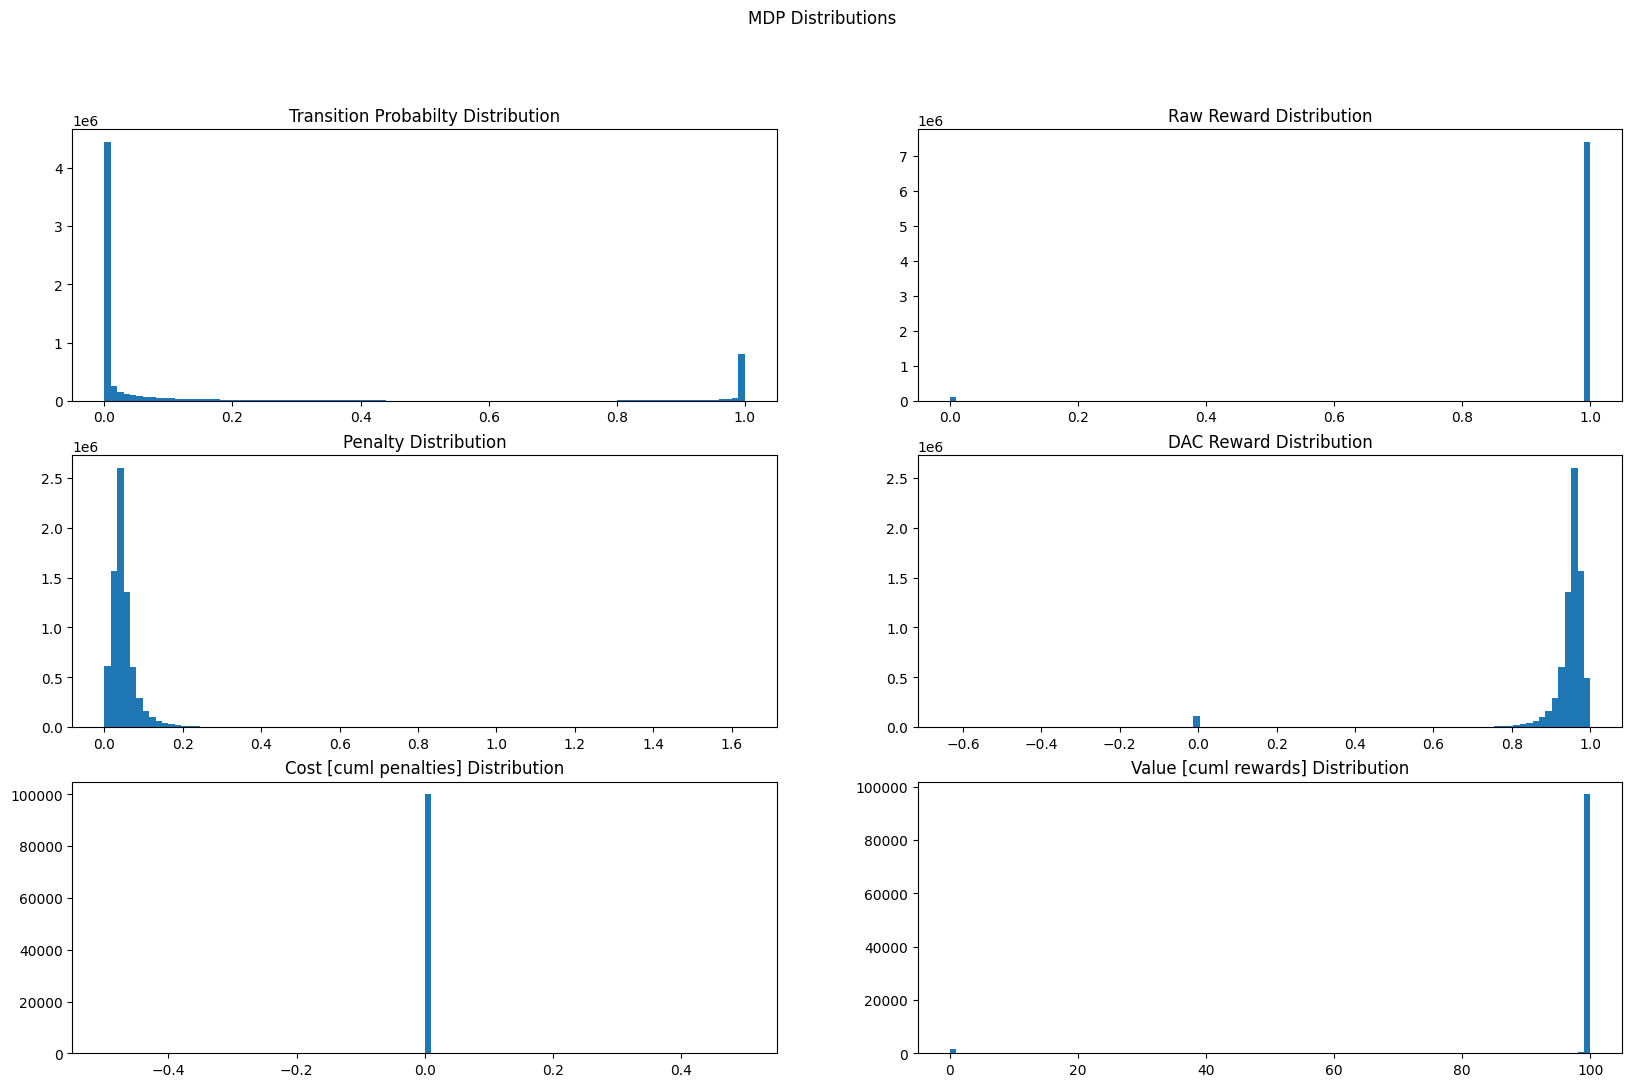

In [11]:
image_array= plot_distributions_as_rgb_array(elasticAgent.dacmdp_core.mdp_distributions)


In [12]:
elasticAgent.dacmdp_core.solve(max_n_backups = config.mdpSolveArgs.max_n_backups, 
                               penalty_beta = 10 ,
                               epsilon = config.mdpSolveArgs.epsilon, 
                               gamma = config.mdpSolveArgs.gamma, 
                               operator="simple_backup", 
                               bellman_backup_batch_size=500)

######### TT 4: Eval  ###########################################################################
st = time.time()
eval_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0)
config.evalArgs.eval_episode_count = 100
avg_rewards, info = evaluate_on_env(env, eval_policy, eps_count=config.evalArgs.eval_episode_count)
eval_time =  time.time()-st
print(f"Epoch {epoch_i}: Evaluation compltete", avg_rewards, "Time: ",eval_time, "Seconds")

0 tensor(1.)
500 tensor(0.0067)
1000 tensor(0.0001)
1500 tensor(2.2888e-05)
Solved MDP in 1500 Backups


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.69it/s]

Epoch 24: Evaluation compltete 296.25 Time:  13.015323400497437 Seconds


In [50]:
torch.nonzero(transitions.terminals)

tensor([[  335],
        [  419],
        [  491],
        [  760],
        [  825],
        [ 1047],
        [ 1119],
        [ 1676],
        [ 1753],
        [ 2071],
        [ 2158],
        [ 2444],
        [ 2842],
        [ 2867],
        [ 3053],
        [ 3497],
        [ 3688],
        [ 3883],
        [ 4159],
        [ 4218],
        [ 4295],
        [ 4322],
        [ 4467],
        [ 4561],
        [ 4923],
        [ 5023],
        [ 5468],
        [ 5631],
        [ 6216],
        [ 6354],
        [ 6419],
        [ 6521],
        [ 6709],
        [ 7026],
        [ 7058],
        [ 7117],
        [ 7185],
        [ 7307],
        [ 7383],
        [ 7414],
        [ 7500],
        [ 7591],
        [ 7694],
        [ 7870],
        [ 8010],
        [ 8297],
        [ 8506],
        [ 8549],
        [ 8634],
        [ 8780],
        [ 8886],
        [ 9041],
        [ 9206],
        [ 9321],
        [ 9358],
        [ 9635],
        [10200],
        [10637],
        [10673

In [52]:
replace_at_indices[335]

tensor(2183)

In [53]:
2183 in elasticAgent.dacmdp_core.D_terminal_indices

True

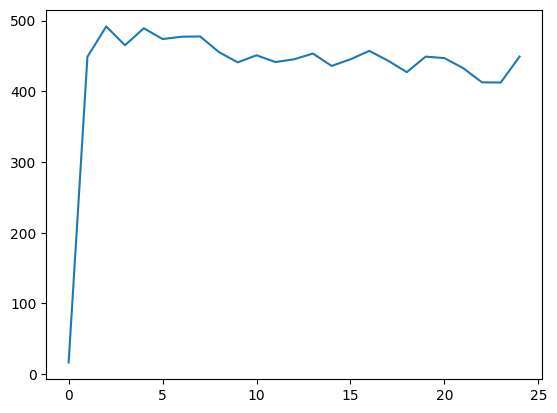

In [14]:
import matplotlib.pyplot as plt 
plt.plot([g["optimal_data_collection_traj_reward"] for g in gen_log])
# plt.plot([g["optimal_data_collection_traj_reward"]*2 for g in gen_log])

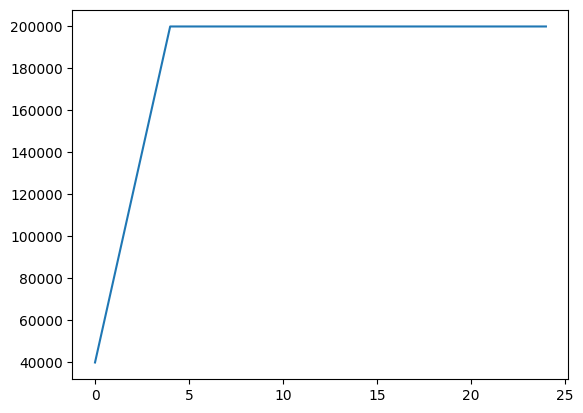

In [15]:
import matplotlib.pyplot as plt 
plt.plot([g["dacmdp_size"] for g in gen_log])
# plt.plot([g["optimal_data_collection_traj_reward"]*2 for g in gen_log])

In [23]:
nn,aa,sa_dim = elasticAgent.dacmdp_core.T_repr[:,5:,:].shape
s_repr = elasticAgent.dacmdp_core.T_repr[:,5:,:].reshape(nn,aa*sa_dim).contiguous()
knn_indices, knn_distances = THelper.batch_calc_knn_pykeops(s_repr, s_repr, k = 2)
nn_distances = knn_distances[:, 1]

[KeOps] Generating code for formula ArgKMin_Reduction(Sum((Var(0,40,0)-Var(1,40,1))**2),0) ... OK


In [26]:
knn_indices[1]

tensor([   1, 8582, 2273, 3935, 7975])

tensor([     4,     30,     46,  ..., 199997, 199998, 199999])

In [43]:
# elasticAgent.dacmdp_core.S

In [21]:
from dacmdp.data.utils_buffer import StandardElasticBuffer
global_buffer = StandardElasticBuffer(state_shape = env.observation_space.shape,
           action_shape = [len(env.action_space.sample())], # for discrete settings. 
            batch_size=32, buffer_size=100000, device="cpu")

data_buffer = StandardBuffer(state_shape = env.observation_space.shape,
                       action_shape = [len(env.action_space.sample())], # for discrete settings. 
                        batch_size=32, buffer_size=point_batch_size, device="cpu")
data_buffer, info_explore = StandardBuffer.populate_buffer(data_buffer, env, 
                                               policy = random_policy,
                                               episode_count=99999, 
                                               frame_count=int(point_batch_size/2))

Average Reward of collected trajectories:17.769


In [22]:
global_buffer.append_buffer(data_buffer)
global_buffer.append_buffer(data_buffer)

In [23]:
print(np.sum(global_buffer.reward), np.sum(data_buffer.reward))

20008.0 10004.0


In [ ]:
64 dimensional 

In [23]:
D1 = torch.randn(int(1e5), 8).cuda()
Q1 = torch.randn(int(1e6), 8).cuda()


Q2 = torch.randn(int(1e5), 16).cuda()
D2 = torch.randn(int(1e6), 16).cuda()


Q3 = torch.randn(int(1e5), 32).cuda()
D3 = torch.randn(int(1e7), 32).cuda()

In [19]:
import time

st = time.time()
knn_indices , knn_distances = THelper.batch_calc_knn_pykeops(D1, D1, k = 5)
torch.cuda.synchronize()
et = time.time()
print(et-st)

2.621091365814209


In [ ]:
400K / S

In [21]:
import time

st = time.time()
knn_indices , knn_distances = THelper.batch_calc_knn_pykeops(D2, D2, k = 5)
torch.cuda.synchronize()
et = time.time()
print(et-st)

[KeOps] Generating code for formula ArgKMin_Reduction(Sum((Var(0,16,0)-Var(1,16,1))**2),0) ... OK
4.716387987136841


In [24]:
import time

st = time.time()
knn_indices , knn_distances = THelper.batch_calc_knn_pykeops(Q3, D3, k = 5)
torch.cuda.synchronize()
et = time.time()
print(et-st)

11.181524753570557


In [ ]:
1OK /s